In [1]:
import numpy as np
from FlagRep import FlagRep
from matplotlib import pyplot as plt
from FlagRep0 import chordal_distance

import pandas as pd

import seaborn as sns

from sklearn.metrics.pairwise import paired_cosine_distances, paired_euclidean_distances

from sklearn.decomposition import PCA

import itertools

from sklearn.manifold import MDS


In [2]:
n_pts = 60
n_clusters = 3

n = 10
col_ids = [20,20]
p = np.sum(col_ids)
hidden_flag_type = [2,4]
hidden_ms = [2,2]
noise_exps = range(1,1000,50)
distributions = ['Normal', 'Exponential', 'Uniform']

In [3]:
rows = n
centers = []
for _ in range(n_clusters):
    center = []
    ProjMat = np.eye(rows)
    for i in range(len(hidden_flag_type)):            
        rank = hidden_ms[i] # Specify the desired rank
        rand_mat = np.random.randn(rows, rank)
        hidden_X = ProjMat @ np.linalg.qr(rand_mat)[0][:,:rank]
        ProjMat = np.eye(rows) - hidden_X @ hidden_X.T
        center.append(hidden_X)
    centers.append(center)


In [4]:
Ds = []
labels = []
for class_num, center in enumerate(centers):
    for _ in range(n_pts//n_clusters):
        D = []
        for i in range(len(hidden_flag_type)): 
            cols = col_ids[i]
            rank = hidden_ms[i]
            low_rank_matrix = np.linalg.qr(center[i]+np.random.normal(scale = .28, size=(rows,rank)))[0][:,:rank]
            D.append(low_rank_matrix@np.random.normal(size= (rank, cols)))
        D = np.hstack(D)
        Ds.append(D)
        labels.append(class_num)

In [5]:


flags = {}
flags['SVD'] = []
flags['FlagRep'] = []
for D in Ds:
    my_flag_rep = FlagRep(Aset = [np.arange(col_ids[0]),np.arange(p)], solver = 'svd', flag_type=[2,4])
    flagrep_X = my_flag_rep.fit_transform(D)

    U = np.linalg.svd(D)[0][:,:4]            
    svd_errs = []
    col_orderings = []
    for comb in itertools.combinations([0,1,2,3], 2):
        my_flag_rep = FlagRep(Aset = [np.arange(col_ids[0]),np.arange(p)], flag_type=[2,4])
        id1 = np.array(list(set([0,1,2,3]).difference(set(list(comb)))))
        col_ordering = np.hstack([id1,np.array(comb)])
        svd_errs.append(my_flag_rep.objective_value(U[:,col_ordering],D))
        col_orderings.append(col_ordering)
    best_idx = np.argmin(svd_errs)
    err_svd = svd_errs[best_idx]
    svd_X = U[:,col_orderings[best_idx]]
    

    flags['SVD'].append(svd_X)
    flags['FlagRep'].append(flagrep_X)

In [6]:
def make_Bs(fl_type):
    Bs = [np.arange(fl_type[0])]
    for i in range(1,len(fl_type)):
        Bs.append(np.arange(fl_type[i-1],fl_type[i]))
    return Bs

Bs = make_Bs(hidden_flag_type)

dist_mats = {}
dist_mats['SVD'] = np.zeros((n_pts,n_pts))
dist_mats['FlagRep'] = np.zeros((n_pts,n_pts))
for method_name in ['SVD', 'FlagRep']:
    for i in range(n_pts):
        for j in range(i+1,n_pts):
            x = flags[method_name][i]
            y = flags[method_name][j]
            dist = chordal_distance(x, y, Bs, Bs)
            dist_mats[method_name][i,j] = dist
            dist_mats[method_name][j,i] = dist

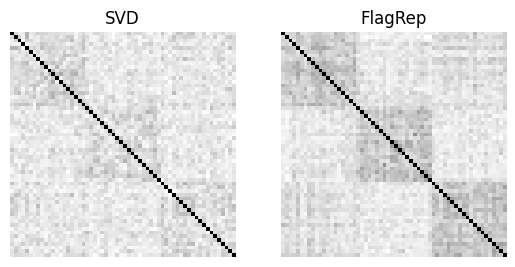

In [7]:
fig, ax = plt.subplots(1,2)
for i, method_name in enumerate(dist_mats.keys()):
    ax[i].imshow(dist_mats[method_name], cmap = 'grey')
    ax[i].set_title(method_name)
    ax[i].axis('off')

plt.savefig('../results/synthetic_clustering.pdf', bbox_inches = 'tight')

In [8]:
Ds_reduced = {}

Ds_flat = np.vstack([D.flatten() for D in Ds])
my_pca = PCA(n_components = 2)
Ds_reduced['PCA'] = my_pca.fit_transform(Ds_flat) 

for method_name in ['SVD','FlagRep']:
    my_mds = MDS(dissimilarity = 'precomputed')
    Ds_reduced[method_name] = my_mds.fit_transform(dist_mats[method_name])



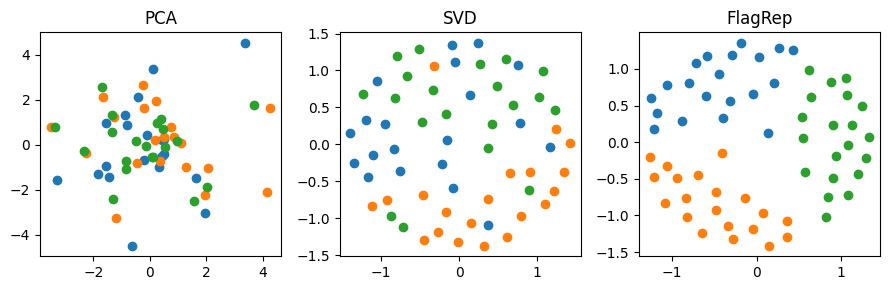

In [9]:
fig, ax = plt.subplots(1,3, figsize = (9,3))
for i, method_name in enumerate(['PCA', 'SVD', 'FlagRep']):
    for l in np.unique(labels):
        idx = np.where(labels == l)[0]
        ax[i].scatter(Ds_reduced[method_name][idx,0], Ds_reduced[method_name][idx,1])
    ax[i].set_title(method_name)
plt.tight_layout()
plt.savefig('../results/synthetic_clustering_dr.pdf', bbox_inches = 'tight')